# ELT 575 - Aprendizado Profundo
## Atividade 3
### Aluno: José Eduardo de Souza Pimentel

# PARTE 1

**1 - Qual a principal diferença entre uma rede MLP feedforward e uma rede neural recorrente (RNN)? Como essa diferença ajuda a RNN a processar dados que tenham uma forma sequencial?**

A principal diferença entre uma rede MLP feedforward e uma RNN reside no fato de que naquela a informação flui num único sentido, da entrada para a saída, enquanto nesta, a recorrência faz com que os neurônios sejam realimentados, isto é, recebam informações de um instante de tempo anterior.

Para que isso seja possível, cada neurônio que compõe a rede é, na verdade, um conjunto de neurônios incumbidos de processar as informações do instante anterior, como demonstra a figura abaixo.

Figura 1

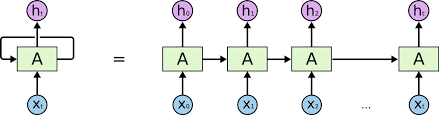

Fonte: Medium. Disponível em <https://medium.com/@web2ajax/redes-neurais-recorrentes-lstm-b90b720dc3f6>. Acesso em 24 fev. 2023.

**2 - Qual a diferença da técnica Backpropagation Through Time (BPTT) e o Backpropagation convencional?**

Na Backpropagation Through Time (BPTT) ou retropropagação através do tempo, característica da rede recorrente, a retropropagação ocorre de cima para baixo e da direita para a esquerda, conforme sugere a Figura 1 acima reproduzida. Decorrre que "em cada intervalo de tempo ou passo de tempo t (também chamado frame), este neurônio recorrente recebe as entradas x(t) bem como o seu próprio intervalo de tempo anterior y(t-1)" (GÉRON, 2021, p. 385). Tal característica difere da Backpropagation convencional, na qual a retropropagação ocorre tão somente da direita para a esquerda.

**3 - Ao contrário de uma CNN, o treinamento de uma RNN apresenta dificuldade de ser paralelizado. Baseado na composição de uma RNN e do processo de Backpropagation Through Time, explique o que causa essa dificuldade.**

Redes RNN não devem ser paralelizadas, a princípio, porque seu processamento depende do estado anterior, ou seja, de informações obtidas no momento anterior. Logo, a paralelização concorre para que tais informações sejam perdidas. De qualquer modo, deve-se destacar que existem ténicas que permitem a paralelização das RNN (batch parallelization e layer parallellization), cuja arquitetura refoge ao escopo deste trabalho, mas que, no entanto, têm seu desempenho comprometido pelo processo.

**4 - As redes utilizando células Long Short Term Memory (LSTM) são um dos tipos mais populares de RNRs, fazendo uso de unidades que contém um forget gate que decide se a informação daquela célula deve ou não ser esquecida em um dado momento do tempo. Explique como funciona esse mecanismo e qual sua vantagem em relação à RNN clássica (sem forget gate).**

As células LSTM são construídas de forma que possam a) selecionar informações que serão preservadas ou descartadas; b) adicionar informação; e c) descartar informação. Isso ocorre conforme as informações passam por "portões" (de entrada, de esquecimento e de saída). Funcionam com dois estados, o de curto (h) e o de longo (c) prazos. Desse modo, conforme a informação se propagada pelas células desse tipo, novas memórias são adicionadas ao estado de longo prazo e outras são apagadas. O estado c passa por uma função tanh, é multiplicado, e produz um estado de curto prazo h(t), que corresponde à saída do intervalo de tempo multiplicado pelo peso da saída da unidade.

Assim, a célula LSTM mitiga o problema do gradiente nas RNN, pois faz com que a rede conserve as informações mais relevantes por um longo período de tempo. A unidade acelera o treinamento e detectará as dependências de longo prazo mais facilmente.

Fig. 2

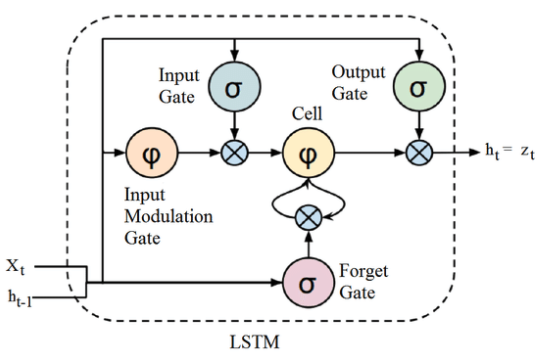

Fonte: Deeplearningbook.com.br. Acesso em: 24 fev. 2023. 

# PARTE 2


Modifique o exemplo Series_prediction_RNN para fazer a previsão da série temporal envolvendo as ações da Tesla (arquivo tesla_stock_2015_2022.csv, em anexo). É necessário fazer o download do arquivo para a máquina local de vocês e então fazer o upload dele para o Google Drive. Faça a mesma separação de os últimos 20 % da série como conjunto de teste.

Inicie com uma única camada LSTM, como no exemplo original, mas com 50 unidades ocultas. Reporte o resultado como feito no exemplo (Raíz do Erro Médio Quadrático e plot de valores das ações vs. valores previstos) 

Experimente adicionar mais uma camada LSTM após a primeira (mesmo número de unidades ocultas do item anterior). Reporte o resultado da mesma forma que o item anterior e comente se houve melhora

Dica: para conectar duas camadas LSTM do Tensorflow, devemos usar o parâmetro return_sequences=True. A última camada LSTM antes da Dense deve ser setada para return_sequences=False.

```python
model.add(LSTM(hidden_units, input_shape=input_shape, return_sequences=True, activation=activation[0]))
```

Adicione um Dropout de 20% após cada camada LSTM e reporte se houve melhora.

Finalmente, modifique o modelo para que ele tenha 4 blocos LSTM (50 unidades ocultas) + Dropout (20 %) antes da camada Dense. Reporte os resultados deste último modelo e compare com os demais



In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

# Importando dados e conhecendo o dataframe

Para a importação dos dados, carregamos o dataset fornecido no Drive, conectando-o ao Colab.

In [2]:
url = '/content/drive/MyDrive/Datasets/tesla_stock_2015_2022 (4).csv'
df = pd.read_csv(url)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-09,51.816002,52.590000,51.358002,51.584000,51.584000,16670500
1,2015-07-10,52.444000,52.599998,51.563999,51.830002,51.830002,13054500
2,2015-07-13,52.450001,52.509998,51.209999,52.431999,52.431999,14801500
3,2015-07-14,52.419998,53.198002,52.102001,53.130001,53.130001,9538000
4,2015-07-15,53.348000,53.498001,52.416000,52.627998,52.627998,10108000


In [3]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1644.000000,1644.000000,1644.000000,1644.000000,1644.000000,1.644000e+03
mean,208.321319,212.803601,203.500151,208.453633,208.453633,3.941615e+07
std,283.517644,289.756782,276.605004,283.649343,283.649343,2.866861e+07
min,28.464001,30.993999,28.209999,28.733999,28.733999,3.540000e+06
25%,48.599998,49.361499,47.728999,48.589000,48.589000,2.161772e+07
50%,63.399000,64.647004,62.300999,63.476000,63.476000,3.056825e+07
75%,178.216999,181.898995,173.480003,177.964001,177.964001,4.606955e+07
max,1234.410034,1243.489990,1217.000000,1229.910034,1229.910034,3.046940e+08


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1644 entries, 0 to 1643
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1644 non-null   object 
 1   Open       1644 non-null   float64
 2   High       1644 non-null   float64
 3   Low        1644 non-null   float64
 4   Close      1644 non-null   float64
 5   Adj Close  1644 non-null   float64
 6   Volume     1644 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 90.0+ KB


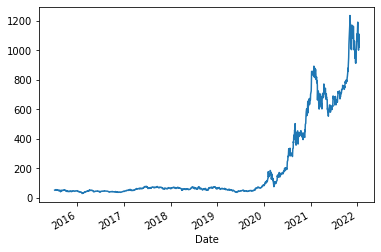

In [5]:
df.index = pd.to_datetime(df.Date)
df.Open.plot()
plt.show()

In [6]:
def get_train_test(url, split_percent=0.8):
    df = pd.read_csv(url, usecols=[1], engine='python')
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data
 
train_data, test_data, data = get_train_test(url)

# Preparação dos dados

Para preparar os dados para a rede recorrente, devemos quebrar a série temporal em vetores de tamanho igual ao número de entradas da nossa rede (estamos considerando assim quantos time steps passados estamos usando para prever o time step atual)

In [7]:
# Prepare the input X and target Y
def get_XY(dat, time_steps):
    # Indices of target array
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    # Prepare X
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))    
    return X, Y
 
time_steps = 12
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

In [8]:
trainX.shape

(109, 12, 1)

# Modelo original (modificado para 50 camadas ocultas)

Usaramos aqui uma rede recorrente simples com 50 unidades ocultas que utilizam 12 passos anteriores para estimar o atual estado. O resultado é avaliado por um único neurônio totalmente conectado que nos dá a saída da rede
* Função de ativação tanh em ambas as camadas da rede.

* Como função objetiva, usaremos o erro médio quadrático, já que estamos lidando com um problema de predição

In [9]:
# A função do modelo original foi modificada para que trabalhe com 50 camadas ocultas

def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=input_shape,
                   activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_RNN(hidden_units=50, dense_units=1, input_shape=(time_steps,1), 
                   activation=['tanh', 'tanh'])
model.fit(trainX, trainY, validation_data=(testX, testY), epochs=20, batch_size=1, verbose=2)

Epoch 1/20
109/109 - 9s - loss: 8.6628e-04 - val_loss: 0.0118 - 9s/epoch - 82ms/step
Epoch 2/20
109/109 - 1s - loss: 1.4372e-04 - val_loss: 0.0086 - 1s/epoch - 10ms/step
Epoch 3/20
109/109 - 1s - loss: 1.6349e-04 - val_loss: 0.0031 - 1s/epoch - 10ms/step
Epoch 4/20
109/109 - 1s - loss: 7.9786e-05 - val_loss: 0.0030 - 1s/epoch - 10ms/step
Epoch 5/20
109/109 - 1s - loss: 2.3208e-04 - val_loss: 0.0386 - 1s/epoch - 11ms/step
Epoch 6/20
109/109 - 1s - loss: 1.6080e-04 - val_loss: 0.0046 - 1s/epoch - 11ms/step
Epoch 7/20
109/109 - 1s - loss: 1.0929e-04 - val_loss: 0.0061 - 1s/epoch - 9ms/step
Epoch 8/20
109/109 - 2s - loss: 8.5329e-05 - val_loss: 0.0030 - 2s/epoch - 17ms/step
Epoch 9/20
109/109 - 2s - loss: 6.0086e-05 - val_loss: 0.0058 - 2s/epoch - 16ms/step
Epoch 10/20
109/109 - 3s - loss: 6.7633e-05 - val_loss: 0.0041 - 3s/epoch - 28ms/step
Epoch 11/20
109/109 - 1s - loss: 1.3709e-04 - val_loss: 0.0157 - 1s/epoch - 11ms/step
Epoch 12/20
109/109 - 1s - loss: 7.8843e-05 - val_loss: 0.0075 -

## Avaliando o treinamento

Primeiro avaliamos o erro médio quadrático do conjunto de treino e de teste

In [10]:
def print_error(trainY, testY, train_predict, test_predict):    
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Raíz do Erro Médio Quadrático para Treino: %.3f' % (train_rmse))
    print('Raíz do Erro Médio Quadrático para Teste: %.3f' % (test_rmse))    
 
# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
# Mean square error
print_error(trainY, testY, train_predict, test_predict)

1/1 [==============================] - 0s 41ms/step
Raíz do Erro Médio Quadrático para Treino: 0.007
Raíz do Erro Médio Quadrático para Teste: 0.077


Podemos também plotar como as nossas previsões se comparam com a série temporal original, como mostrado abaixo

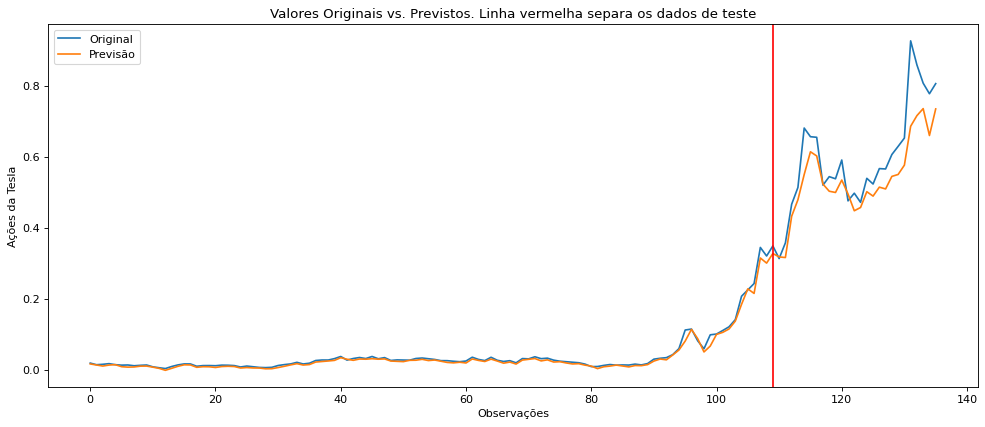

In [11]:
# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Original', 'Previsão'])
    plt.xlabel('Observações')
    plt.ylabel('Ações da Tesla')
    plt.title('Valores Originais vs. Previstos. Linha vermelha separa os dados de teste')
plot_result(trainY, testY, train_predict, test_predict)

# Modelo com a adição de uma camada LSTM

In [12]:
# Adicionando uma camada LSTM

def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=input_shape, activation=activation[0], return_sequences=True))
    model.add(LSTM(hidden_units))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_RNN(hidden_units=50, dense_units=1, input_shape=(time_steps,1), 
                   activation=['tanh', 'tanh'])
model.fit(trainX, trainY, validation_data=(testX, testY), epochs=20, batch_size=1, verbose=2)

Epoch 1/20
109/109 - 6s - loss: 0.0020 - val_loss: 0.0043 - 6s/epoch - 56ms/step
Epoch 2/20
109/109 - 1s - loss: 2.1029e-04 - val_loss: 0.0074 - 1s/epoch - 10ms/step
Epoch 3/20
109/109 - 1s - loss: 2.9300e-04 - val_loss: 0.0247 - 1s/epoch - 10ms/step
Epoch 4/20
109/109 - 1s - loss: 1.7286e-04 - val_loss: 0.0283 - 983ms/epoch - 9ms/step
Epoch 5/20
109/109 - 1s - loss: 2.2545e-04 - val_loss: 0.0113 - 1s/epoch - 10ms/step
Epoch 6/20
109/109 - 1s - loss: 8.1922e-05 - val_loss: 0.0030 - 1s/epoch - 9ms/step
Epoch 7/20
109/109 - 2s - loss: 1.1146e-04 - val_loss: 0.0072 - 2s/epoch - 14ms/step
Epoch 8/20
109/109 - 2s - loss: 4.6375e-04 - val_loss: 0.0040 - 2s/epoch - 14ms/step
Epoch 9/20
109/109 - 1s - loss: 2.1942e-04 - val_loss: 0.0087 - 1s/epoch - 12ms/step
Epoch 10/20
109/109 - 1s - loss: 6.2442e-05 - val_loss: 0.0077 - 1s/epoch - 10ms/step
Epoch 11/20
109/109 - 1s - loss: 5.9287e-05 - val_loss: 0.0034 - 991ms/epoch - 9ms/step
Epoch 12/20
109/109 - 1s - loss: 1.2883e-04 - val_loss: 0.0031 -

In [13]:
# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
# Mean square error
print_error(trainY, testY, train_predict, test_predict)

1/1 [==============================] - 0s 29ms/step
Raíz do Erro Médio Quadrático para Treino: 0.013
Raíz do Erro Médio Quadrático para Teste: 0.073


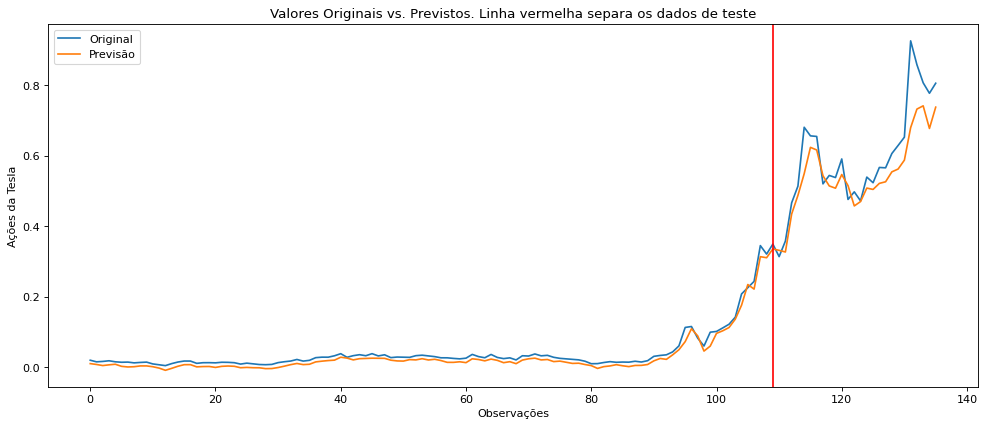

In [14]:
# Plot the result
plot_result(trainY, testY, train_predict, test_predict)

# Modelo anterior com a adição de Dropout (0.2)

In [15]:
# Modelo anterior com Dropout

def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=input_shape, activation=activation[0], return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(hidden_units))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_RNN(hidden_units=50, dense_units=1, input_shape=(time_steps,1), 
                   activation=['tanh', 'tanh'])
model.fit(trainX, trainY, validation_data=(testX, testY), epochs=20, batch_size=1, verbose=2)

Epoch 1/20
109/109 - 5s - loss: 5.9940e-04 - val_loss: 0.0092 - 5s/epoch - 50ms/step
Epoch 2/20
109/109 - 1s - loss: 2.5253e-04 - val_loss: 0.0040 - 1s/epoch - 9ms/step
Epoch 3/20
109/109 - 1s - loss: 1.1204e-04 - val_loss: 0.0033 - 956ms/epoch - 9ms/step
Epoch 4/20
109/109 - 1s - loss: 1.4600e-04 - val_loss: 0.0035 - 960ms/epoch - 9ms/step
Epoch 5/20
109/109 - 1s - loss: 2.8838e-04 - val_loss: 0.0580 - 1s/epoch - 11ms/step
Epoch 6/20
109/109 - 2s - loss: 8.9208e-04 - val_loss: 0.0435 - 2s/epoch - 14ms/step
Epoch 7/20
109/109 - 2s - loss: 5.1136e-04 - val_loss: 0.0160 - 2s/epoch - 14ms/step
Epoch 8/20
109/109 - 2s - loss: 9.1125e-05 - val_loss: 0.0067 - 2s/epoch - 16ms/step
Epoch 9/20
109/109 - 2s - loss: 1.3690e-04 - val_loss: 0.0196 - 2s/epoch - 15ms/step
Epoch 10/20
109/109 - 2s - loss: 1.4373e-04 - val_loss: 0.0033 - 2s/epoch - 19ms/step
Epoch 11/20
109/109 - 3s - loss: 1.0516e-04 - val_loss: 0.0056 - 3s/epoch - 23ms/step
Epoch 12/20
109/109 - 1s - loss: 6.1900e-05 - val_loss: 0.00

In [16]:
# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
# Mean square error
print_error(trainY, testY, train_predict, test_predict)

1/1 [==============================] - 0s 30ms/step
Raíz do Erro Médio Quadrático para Treino: 0.007
Raíz do Erro Médio Quadrático para Teste: 0.077


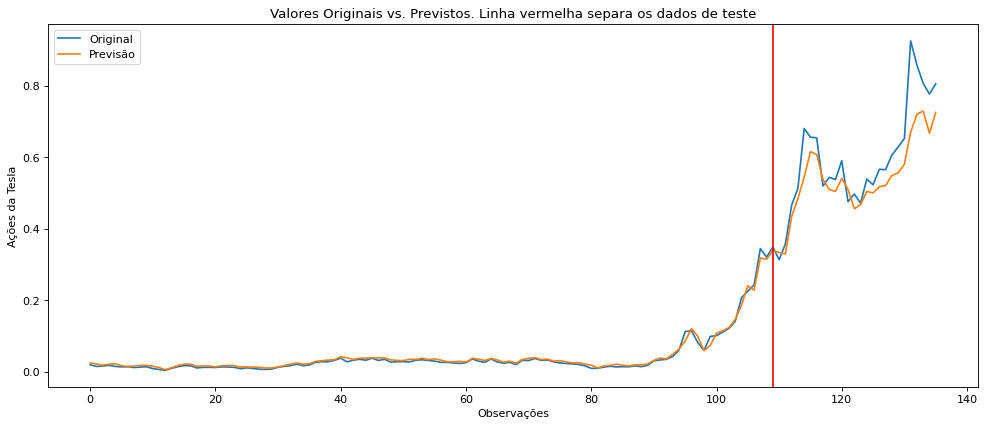

In [17]:
# Plot the result
plot_result(trainY, testY, train_predict, test_predict)

# Alterando o Dropout para 0.5 (extra)



In [18]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=input_shape, activation=activation[0], return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(hidden_units))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_RNN(hidden_units=50, dense_units=1, input_shape=(time_steps,1), 
                   activation=['tanh', 'tanh'])
model.fit(trainX, trainY, validation_data=(testX, testY), epochs=20, batch_size=1, verbose=2)

Epoch 1/20
109/109 - 7s - loss: 5.5175e-04 - val_loss: 0.0033 - 7s/epoch - 66ms/step
Epoch 2/20
109/109 - 1s - loss: 1.4714e-04 - val_loss: 0.0054 - 1s/epoch - 11ms/step
Epoch 3/20
109/109 - 1s - loss: 4.9359e-04 - val_loss: 0.0080 - 1s/epoch - 9ms/step
Epoch 4/20
109/109 - 1s - loss: 1.1496e-04 - val_loss: 0.0049 - 985ms/epoch - 9ms/step
Epoch 5/20
109/109 - 1s - loss: 4.7503e-04 - val_loss: 0.0173 - 980ms/epoch - 9ms/step
Epoch 6/20
109/109 - 1s - loss: 2.3837e-04 - val_loss: 0.0045 - 982ms/epoch - 9ms/step
Epoch 7/20
109/109 - 1s - loss: 1.4083e-04 - val_loss: 0.0059 - 975ms/epoch - 9ms/step
Epoch 8/20
109/109 - 1s - loss: 8.0630e-05 - val_loss: 0.0064 - 1s/epoch - 10ms/step
Epoch 9/20
109/109 - 1s - loss: 1.8445e-04 - val_loss: 0.0032 - 1s/epoch - 10ms/step
Epoch 10/20
109/109 - 1s - loss: 7.9166e-05 - val_loss: 0.0201 - 1s/epoch - 10ms/step
Epoch 11/20
109/109 - 1s - loss: 1.3029e-04 - val_loss: 0.0029 - 978ms/epoch - 9ms/step
Epoch 12/20
109/109 - 2s - loss: 5.9671e-04 - val_loss

In [19]:
# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
# Mean square error
print_error(trainY, testY, train_predict, test_predict)

1/1 [==============================] - 0s 45ms/step
Raíz do Erro Médio Quadrático para Treino: 0.009
Raíz do Erro Médio Quadrático para Teste: 0.058


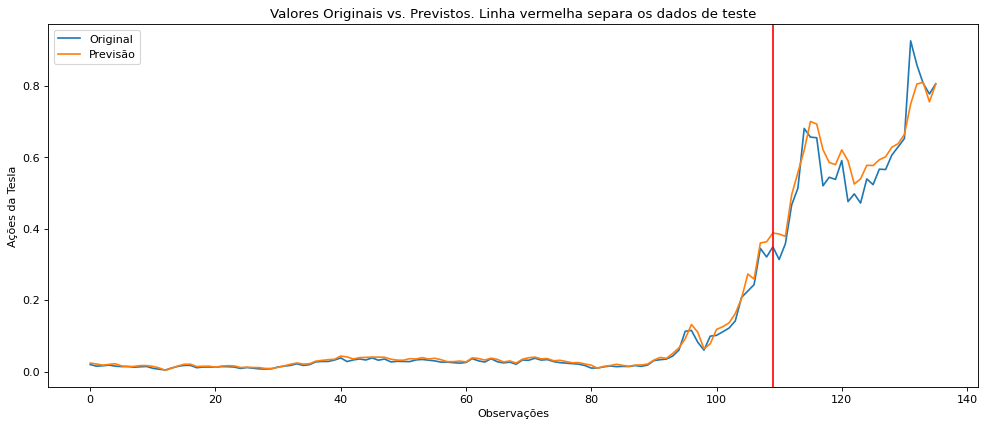

In [20]:
plot_result(trainY, testY, train_predict, test_predict)

# Conclusão

**1) Modelo original modificado para 50 camadas ocultas:**

* Raiz do Erro Médio Quadrático para Treino: 0.007

* Raiz do Erro Médio Quadrático para Teste: 0.077

**2) Modelo anterior com adição de uma camada LSTM:**

* Raiz do Erro Médio Quadrático para Treino: 0.013

* Raiz do Erro Médio Quadrático para Teste: 0.073

**3) Modelo anterior com Dropout de 0.2 entre as camadas LSTM:**

* Raiz do Erro Médio Quadrático para Treino: 0.007

* Raiz do Erro Médio Quadrático para Teste: 0.077

**4) Modelo anterior com Dropout de 0.5 entre as camadas LSTM:**

* Raiz do Erro Médio Quadrático para Treino: 0.009

* Raiz do Erro Médio Quadrático para Teste: 0.058

# Referências

GÉRON, Aurélien. **Mãos à obra: aprendizado de máquina com Scikit-Learn, Keras & TensorFlow.** 2a. ed. atual. Rio de Janeiro: Alta Books, 2021.

SILVA, Pedro Sérgio Tôrres Figueiredo. **Aprendizado profundo**. [apostila]. Viçosa: UFV [s.d.].